# LAMA into the Wild Part1: DataPreperation

# Overview

In this section We will preprocess the Data that we needed in the whole program. The result will be stored in `../data/pre`

In [165]:
import os
import gc

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data import DATA_DIR
from lama.util.StreamerBuilder import StreamerBuilder, to_tuple, identity
from lama.preprocessing.DataProcessor import nans, change_object_col, reformat_dataframe, split_with_index, standarize_col

# 1.1 Define Global Constants

To make our reading and writing more easier, we decide to define some global constants below, you can change them if you'd like to write to another location.

In [166]:
OUT_DIR = os.path.join(DATA_DIR, "pre")

The process looks alike, we will handle them one by one.

- filter out Nan values
- check unique columns
- convert object values to numericals
- catagorize discrete and continous features
- scaling columns with Standardizer or Normalizer. 

# Train and Test

We will first handle train and test dataset.

In [167]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), header=0)
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), header=0)

* check nans

In [168]:
# check nans
print(f'df_test nans: \n{nans(df_test)}\n')
print(f'df_train nans: \n{nans(df_train)}\n')

df_test nans: 
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

df_train nans: 
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64



We can see that in `df_test` there is one nan row, although it is trival compared to the total value, we choose to drop it. 

In [169]:
df_test_copy = df_test.dropna()

Before we go on to next section. lets check if there is abnormal distribution in train dataset.

unexpected value: 2207


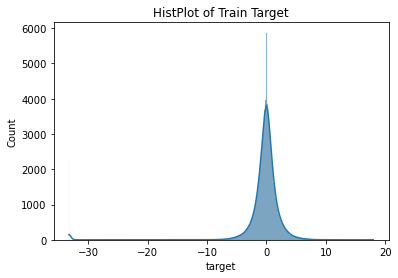

In [170]:
sns.histplot(df_train['target'], kde=True).set(title="HistPlot of Train Target")
unexpected = (df_train['target'] < -30).sum()
print(f'unexpected value: {unexpected}')

Clearly there exists some unexpected values when target < -30.


One more thing to notice is the distributiton is symmetric to 0. 

[Text(0.5, 1.0, 'HistPlot of Train Target')]

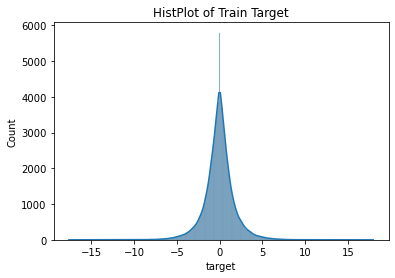

In [171]:
df_train_copy = df_train[df_train['target'] > -30]
sns.histplot(df_train_copy['target'], kde=True).set(title="HistPlot of Train Target")

then we check if the id is unique, this procedure is important as we might need to outer join other datasets with id. 

In [172]:
train_count = df_train_copy.shape[0]
test_count = df_test_copy.shape[0]
print(df_train_copy['card_id'].nunique() == train_count)
print(df_test_copy['card_id'].nunique() == test_count)

True
True


In [173]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199710 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  199710 non-null  object 
 1   card_id             199710 non-null  object 
 2   feature_1           199710 non-null  int64  
 3   feature_2           199710 non-null  int64  
 4   feature_3           199710 non-null  int64  
 5   target              199710 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 10.7+ MB


Now we have to convert obejct to numeric values, as we seen above, there are two object values, since the card_id is a foreign key bound to match more features in other dataset, we'll leave it intact. 

In [174]:
features = ['first_active_month']
df_temps = reformat_dataframe(df_test_copy.append(df_train_copy), features, change_object_col)
df_test_copy, df_train_copy = to_tuple(split_with_index(df_temps, test_count))
del df_temps

After change the columns we would like to see if the train and test features are evenly splitted.

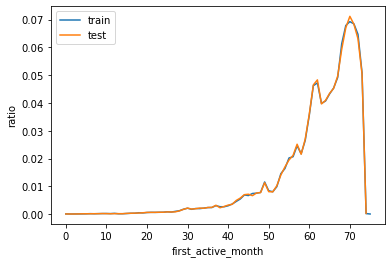

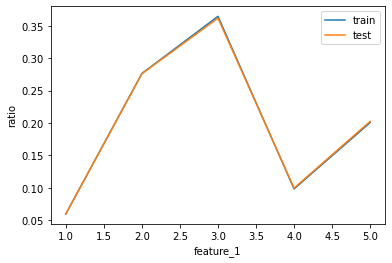

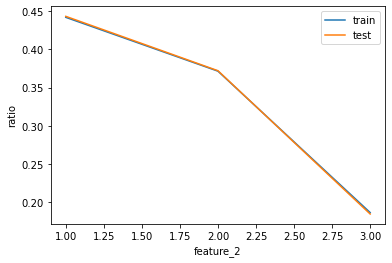

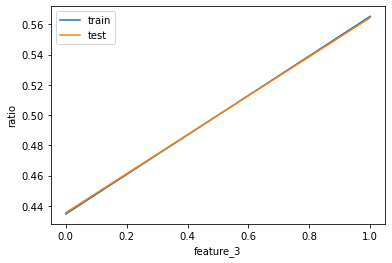

In [175]:
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']
for feature in features:
    (df_train_copy[feature].value_counts().sort_index() / train_count).plot()
    (df_test_copy[feature].value_counts().sort_index() / test_count).plot()
    plt.legend(['train', 'test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

Now we need to standarize the features, since not every model need standarized data, we will just leave the builder here uncollected.  

In [176]:
builder = StreamerBuilder.build([df_test_copy, df_train_copy]) \
    .map(lambda df: reformat_dataframe(df, features, standarize_col))

Last step is to write the result back, and fetch when we needed.

In [177]:
df_test_copy.to_csv(os.path.join(OUT_DIR, 'test_pre.csv'), index=False)
df_train_copy.to_csv(os.path.join(OUT_DIR, 'train_pre.csv'), index=False)

del df_test, df_test_copy, df_train, df_train_copy, features, test_count, train_count, unexpected
gc.collect()

70036

# Merchant Data purge

Now we will hava a look at merchants.csv

In [178]:
df_merchant = pd.read_csv(os.path.join(DATA_DIR, 'merchants.csv'), header=0)
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [179]:
print (df_merchant.shape[0], df_merchant['merchant_id'].nunique())
nans(df_merchant)


334696 334633


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

Obviously, there exists some merchant whose id appears multiple times in this dataset. In catagory_2 lacks a significant amount of datas. We will check the unique value from category 4 to see if it is possible to repace nans to 0

We will change the object columns to numerical ones.

In [182]:


merchants_category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
                 'subsector_id', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'city_id', 'state_id', 'category_4', 'category_2']

merchants_numeric_cols = ['numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
                'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

assert len(merchants_numeric_cols) + len(merchants_category_cols) == len(df_merchant.columns)

0         0
1         0
2         0
16        0
17        0
         ..
334691    0
334692    1
334693    0
334694    1
334695    0
Name: category_1, Length: 334683, dtype: int64


check category columns unique values

In [186]:
df_merchant[merchants_category_cols].nunique()
df_merchant[merchants_category_cols].dtypes
df_merchant['category_2'] .unique()
df_merchant['category_2'] = df_merchant['category_2'].fillna(-1)

cols = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']
df_merchant = reformat_dataframe(df_merchant, cols, change_object_col)
print(df_merchant)

            merchant_id  merchant_group_id  merchant_category_id  \
0       M_ID_838061e48c               8353                   792   
1       M_ID_9339d880ad               3184                   840   
2       M_ID_e726bbae1e                447                   690   
3       M_ID_a70e9c5f81               5026                   792   
4       M_ID_64456c37ce               2228                   222   
...                 ...                ...                   ...   
334691  M_ID_1f4773aa76               1145                   705   
334692  M_ID_725a60d404                 35                   544   
334693  M_ID_f2045dd267                 35                   561   
334694  M_ID_9139332ccc                 35                   511   
334695  M_ID_cd2c0b07e9                 35                   606   

        subsector_id  numerical_1  numerical_2  category_1  \
0                  9    -0.057471    -0.057471           0   
1                 20    -0.057471    -0.057471           0 

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                       int64
most_recent_sales_range          int64
most_recent_purchases_range      int64
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                       int64
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [190]:
df_merchant[merchants_numeric_cols].dtypes
nans(df_merchant)
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,...,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,inf,...,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,NaN,...,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,3.334953e-01,...,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,9.236499e-01,...,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667e+00,...,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522e+00,...,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,inf,...,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,1.000000,347.000000,24.000000,5.000000


In [191]:
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']

# replace infinity with second largest values
df_merchant = reformat_dataframe(df_merchant, inf_cols, lambda df: df.replace(np.inf, df[df != np.inf].max()))
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,...,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,2.145143,...,2.165079e+01,2.390194,5.947397,2.522771e+01,2.529277,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,213.955844,...,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,0.333495,...,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,0.923650,...,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667,...,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522,...,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,61851.333333,...,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,1.000000,347.000000,24.000000,5.000000


Fill nans with mean values

In [194]:
df_merchant = reformat_dataframe(df_merchant, merchants_numeric_cols, lambda df: df.fillna(df.mean()))


df_merchant.to_csv(os.path.join(OUT_DIR, 'merchants_pre.csv'), index=False)

del df_merchant, inf_cols, cols
gc.collect()

# History Transaction and New Merchant Transaction Data Purge

These two datasets will be purged all together bacause they are highly relevant. In order to process the datasets efficiently we will use a StreamerBuilder to process the data chunk by chunk

In [157]:

chunksize=10 ** 6

def histories_builder() -> StreamerBuilder[pd.DataFrame] :
    return StreamerBuilder.build(pd.read_csv(os.path.join(DATA_DIR, "historical_transactions.csv"),
                       chunksize=chunksize))

def append_df(df1, df2) :
    return df1.append(df2)

df_new_merchants = pd.read_csv(os.path.join(DATA_DIR, "new_merchant_transactions.csv"))
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB
